In [192]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import copy

# Data preparation

## Data loading

In [159]:
raw_data = pd.read_csv("data/archive/train.csv")

In [160]:
raw_data.shape

(103904, 25)

Checking the type of the data

In [161]:
raw_data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [162]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

A quick analysis of the columns tells us that there are basically 2 types of columns:
- Category columns: They contain value from a small discrete set. For example many columns take values between 0 and 5
- Non-category columns: The values contains doesn't seem to be bounded to be part of a small discrete set

## data selection

The first 2 columns do not affect classification, so we remove them

In [163]:
raw_data = raw_data.drop(raw_data.iloc[:,[0, 1]], axis = 1)

Get the different values for the satisfaction

In [164]:
satisfactory_set = tuple(set(raw_data["satisfaction"].values))
print(satisfactory_set)

satisfactory_correspondance = {0: satisfactory_set[0], 1: satisfactory_set[1]}


('neutral or dissatisfied', 'satisfied')


In [165]:
print(satisfactory_correspondance)

{0: 'neutral or dissatisfied', 1: 'satisfied'}


## Data cleaning

Check for missing values

In [166]:
raw_data.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

Some values in Arrival Delay in Minutes feature are missing.

In [167]:
missing_value_ratio = raw_data["Arrival Delay in Minutes"].isna().sum() / raw_data.shape[0]
print(missing_value_ratio)

0.00298352325223283


The missing value represent less than 0.3% of the available data. We can remove the corresponding rows safely without losing generality in the models built.

In [168]:
raw_data = raw_data.dropna()

In [169]:
raw_data.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000
mean,39.380466,1189.325202,2.729753,3.060081,2.756984,2.977026,3.202126,3.250497,3.439765,3.358341,3.382609,3.351401,3.631687,3.304323,3.640761,3.286397,14.747939,15.178678
std,15.113125,997.297235,1.327866,1.525233,1.398934,1.277723,1.329401,1.349433,1.318896,1.333030,1.288284,1.315409,1.181051,1.265396,1.175603,1.312194,38.116737,38.698682
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,842.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


We need to do some formatting of the initial data before constructing new data.

Let's divide columns into categorical columns and not categorical ones

In [170]:
category_index = [0,1,3,4] + list(range(6,20)) + [22]
raw_data.iloc[:, category_index] = raw_data.iloc[:, category_index].astype('category')

In [171]:
categorical_columns = [c for c in raw_data.columns if raw_data[c].dtype.name == 'category']
noncategorical_columns = [c for c in raw_data.columns if raw_data[c].dtype.name != 'category']

In [172]:
categorical_columns

['Gender',
 'Customer Type',
 'Type of Travel',
 'Class',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness',
 'satisfaction']

In [173]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103594 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Gender                             103594 non-null  category
 1   Customer Type                      103594 non-null  category
 2   Age                                103594 non-null  int64   
 3   Type of Travel                     103594 non-null  category
 4   Class                              103594 non-null  category
 5   Flight Distance                    103594 non-null  int64   
 6   Inflight wifi service              103594 non-null  category
 7   Departure/Arrival time convenient  103594 non-null  category
 8   Ease of Online booking             103594 non-null  category
 9   Gate location                      103594 non-null  category
 10  Food and drink                     103594 non-null  category
 11  Online boarding           

## Construct new data

First we separate categories into binary categories and not binary

In [174]:
binary_columns = [c for c in categorical_columns if raw_data[c].nunique() == 2]
nonbinary_columns = [c for c in categorical_columns if raw_data[c].nunique() != 2]

In [175]:
nonbinary_columns

['Class',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness']

In [176]:
binary_columns

['Gender', 'Customer Type', 'Type of Travel', 'satisfaction']

Now we vectorize the non binary categorical features with a one-hot encoding this way:

If a feature can take n values, then we replace it by n binary features. Then one of these new features should have a 1 value and the other a 0 value. \
For example, if the feature number j has a 1 value, and the others have a 0 value, then that means that the initial feature has the j value.

In [177]:
vectorized_data = pd.get_dummies(raw_data[nonbinary_columns])

## Integrating data

Now we need to integrate the new features created appropriately. \
We basically replace the non binary categorical features by their binary counterparts

In [178]:
raw_data = pd.concat([raw_data[noncategorical_columns], raw_data[binary_columns], vectorized_data], axis=1)

In [179]:
raw_data.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Class_Business,Class_Eco,Class_Eco Plus,Inflight wifi service_0,Inflight wifi service_1,Inflight wifi service_2,...,Inflight service_2,Inflight service_3,Inflight service_4,Inflight service_5,Cleanliness_0,Cleanliness_1,Cleanliness_2,Cleanliness_3,Cleanliness_4,Cleanliness_5
count,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,...,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000
mean,39.380466,1189.325202,14.747939,15.178678,0.478145,0.449765,0.072089,0.029886,0.171641,0.248615,...,0.110180,0.195253,0.365330,0.261029,0.000116,0.128154,0.155231,0.236558,0.261598,0.218343
std,15.113125,997.297235,38.116737,38.698682,0.499525,0.497472,0.258637,0.170273,0.377070,0.432212,...,0.313116,0.396397,0.481525,0.439198,0.010762,0.334263,0.362126,0.424971,0.439507,0.413123
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,842.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,1743.000000,12.000000,13.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,85.000000,4983.000000,1592.000000,1584.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Formatting data

First convert the binary features values

In [180]:
raw_data['Gender'].info()

<class 'pandas.core.series.Series'>
Int64Index: 103594 entries, 0 to 103903
Series name: Gender
Non-Null Count   Dtype   
--------------   -----   
103594 non-null  category
dtypes: category(1)
memory usage: 910.6 KB


In [181]:
binary_mapping = {}
for col in binary_columns:
    raw_data[col] = raw_data[col].astype('object')
    print(raw_data[col].info())
    print(col)
    unique_data = list(raw_data[col].unique())
    binary_mapping[col] = [{val: unique_data.index(val) for val in unique_data}]
    raw_data[col] = raw_data[col].map({val: unique_data.index(val) for val in unique_data})
        

<class 'pandas.core.series.Series'>
Int64Index: 103594 entries, 0 to 103903
Series name: Gender
Non-Null Count   Dtype 
--------------   ----- 
103594 non-null  object
dtypes: object(1)
memory usage: 1.6+ MB
None
Gender
<class 'pandas.core.series.Series'>
Int64Index: 103594 entries, 0 to 103903
Series name: Customer Type
Non-Null Count   Dtype 
--------------   ----- 
103594 non-null  object
dtypes: object(1)
memory usage: 1.6+ MB
None
Customer Type
<class 'pandas.core.series.Series'>
Int64Index: 103594 entries, 0 to 103903
Series name: Type of Travel
Non-Null Count   Dtype 
--------------   ----- 
103594 non-null  object
dtypes: object(1)
memory usage: 1.6+ MB
None
Type of Travel
<class 'pandas.core.series.Series'>
Int64Index: 103594 entries, 0 to 103903
Series name: satisfaction
Non-Null Count   Dtype 
--------------   ----- 
103594 non-null  object
dtypes: object(1)
memory usage: 1.6+ MB
None
satisfaction


In [182]:
raw_data['Gender']

0         0
1         0
2         1
3         1
4         0
         ..
103899    1
103900    0
103901    0
103902    1
103903    0
Name: Gender, Length: 103594, dtype: int64

In [183]:
binary_mapping

{'Gender': [{'Male': 0, 'Female': 1}],
 'Customer Type': [{'Loyal Customer': 0, 'disloyal Customer': 1}],
 'Type of Travel': [{'Personal Travel': 0, 'Business travel': 1}],
 'satisfaction': [{'neutral or dissatisfied': 0, 'satisfied': 1}]}

Now for the noncategorical features, we perform a standardization. \
Here we will reduce all values to have zero means and variance 1

In [184]:
raw_data[noncategorical_columns] = (raw_data[noncategorical_columns]-raw_data[noncategorical_columns].mean(axis=0))/raw_data[noncategorical_columns].std(axis=0)

In [185]:
raw_data[binary_columns].describe()

,Gender,Customer Type,Type of Travel,satisfaction
count,103594.000000,103594.000000,103594.000000,103594.000000
mean,0.507520,0.182752,0.689857,0.433394
std,0.499946,0.386465,0.462554,0.495546
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [201]:
data = raw_data.drop('satisfaction', axis = 1)
target = raw_data['satisfaction']

# Data modelling

## Selecting Modeling Techniques
We will select 3 different classifiers:
- Support vector machines
- Random forest
- Stochastic gradient descent

## Generate Test Design

We will split the dataset into: 
- 75% training set
- 25% testing set

In [202]:
data_training, data_test, target_training, target_test = train_test_split(data, target)

data_training = data[: (number_data := (round(len(data)*0.75)))]
data_test = data[number_data:]
target_training = target[:number_data]
target_test = target[number_data:]

## Building the models

First we instanciate the models

In [203]:
models_dict: dict = {
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Stochastic Gradient Descent": SGDClassifier()
}

Train the classifiers

In [204]:
for value in models_dict.values():
    value.fit(data_training, target_training)

# Evaluation: Model Assessment and Evaluation

## Quickly test the models
We can quickly test the models to see if they are accurate in their prediction

In [205]:
# Selecting an item to predict
testing_index = 0
quick_result = target_test.iloc[0]
print(f"The prediction should be: {quick_result} \n")

corresponding_data = data_test.iloc[0]

for key, value in models_dict.items():
    print(f"The model {key} predicts {value.predict([corresponding_data])[0]}")


The prediction should be: 0 

The model Support Vector Machine predicts 0
The model Random Forest predicts 0
The model Stochastic Gradient Descent predicts 0


/Users/jonoillarburu/PythonEnvironments/bootcamp_environment/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/jonoillarburu/PythonEnvironments/bootcamp_environment/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/jonoillarburu/PythonEnvironments/bootcamp_environment/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


## Asssessment on training set

### K-Fold cross validation
We will split the data in 5  folds to use the k-fold cross validation

In [206]:
folds_number: int = 5

for key, value in models_dict.items():
    print(f"The cross validation score for {key} is: {cross_val_score(value, data_training, target_training, cv=folds_number)}")

### Confusion matrix

First use the cross_val_predict to return the predictioin made on each fold

In [152]:
target_training_prediction_dict: dict = {k: cross_val_predict(v, data_training, target_training, cv=folds_number) for k, v in models_dict.items()}

Then for each model draw the confusion matrix

In [153]:
confusion_matrix_dict: dict = {k: confusion_matrix(target_training, v) for k, v in target_training_prediction_dict.items()}

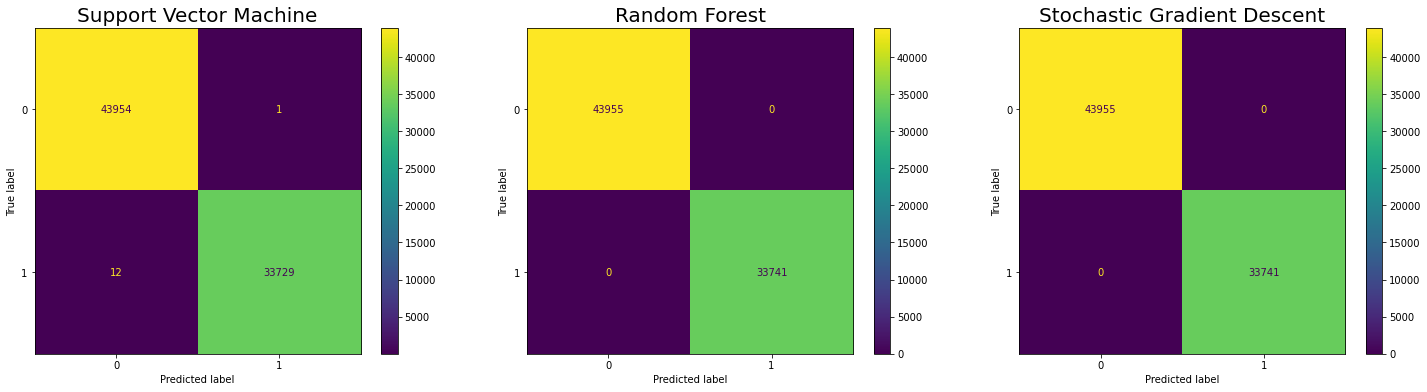

In [154]:
# Draw the confusion matrix:
fig, axs = plt.subplots(1,3, figsize = (25,6))

for i, key in enumerate(confusion_matrix_dict.keys()):
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_dict[key])
    axs[i].set_title(key, fontsize = 20)
    disp.plot(ax=axs[i])


### Different scores
We can compute different metrics on the models:
- Recall
- Precision
- F1 score

In [155]:
scores_dict: dict = {k:
{
    "recall": recall_score(target_training, v),
    "precision": precision_score(target_training, v),
    "F1 score": f1_score(target_training, v)
} for k, v in target_training_prediction_dict.items()}


In [100]:
scores_dict

{'Support Vector Machine': {'recall': 0.9996443496043389,
  'precision': 0.9999703528016602,
  'F1 score': 0.9998073246283589},
 'Random Forest': {'recall': 1.0, 'precision': 1.0, 'F1 score': 1.0},
 'Stochastic Gradient Descent': {'recall': 1.0,
  'precision': 0.9999703633453856,
  'F1 score': 0.9999851814531067}}

## Assessment on testing set

### K-Fold cross validation
We will split the data in 5  folds to use the k-fold cross validation

In [101]:
folds_number: int = 5

for key, value in models_dict.items():
    print(f"The cross validation score for {key} is: {cross_val_score(value, data_test, target_test, cv=folds_number)}")

The cross validation score for Support Vector Machine is: [0.9992278  0.9996139  0.9996139  1.         0.99961383]
The cross validation score for Random Forest is: [1. 1. 1. 1. 1.]
The cross validation score for Stochastic Gradient Descent is: [1. 1. 1. 1. 1.]


### Confusion matrix

First use the cross_val_predict to return the predictioin made on each fold

In [102]:
target_test_prediction_dict: dict = {k: cross_val_predict(v, data_test, target_test, cv=folds_number) for k, v in models_dict.items()}

Then for each model draw the confusion matrix

In [103]:
confusion_matrix_dict: dict = {k: confusion_matrix(target_test, v) for k, v in target_test_prediction_dict.items()}

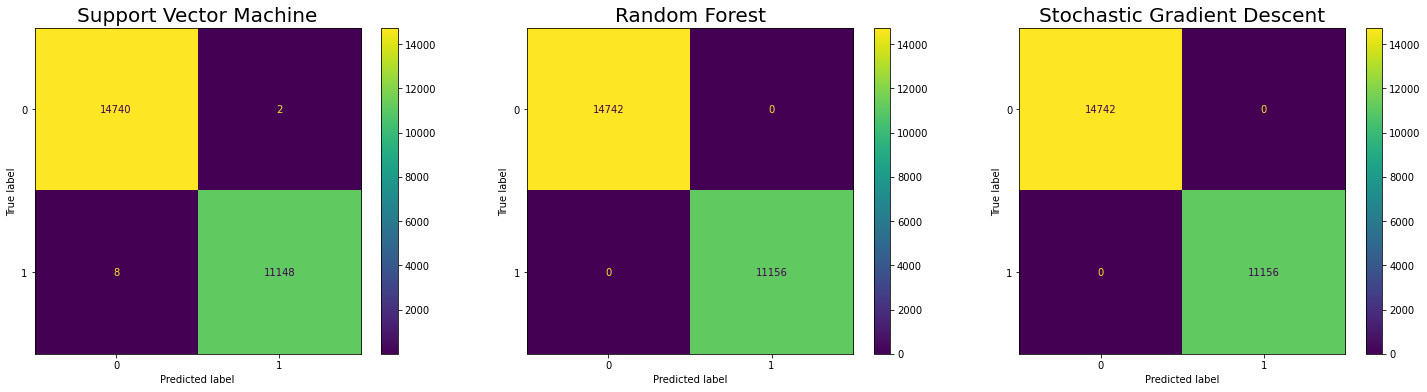

In [117]:
# Draw the confusion matrix:
fig, axs = plt.subplots(1,3, figsize = (25,6))

for i, key in enumerate(confusion_matrix_dict.keys()):
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_dict[key])
    axs[i].set_title(key, fontsize = 20)
    disp.plot(ax=axs[i])


### Different scores
We can compute different metrics on the models:
- Recall
- Precision
- F1 score

In [105]:
scores_dict: dict = {k:
{
    "recall": recall_score(target_test, v),
    "precision": precision_score(target_test, v),
    "F1 score": f1_score(target_test, v)
} for k, v in target_test_prediction_dict.items()}


In [ ]:
scores_dict

{'svm': {'recall': 0.9996443496043389,
  'precision': 0.9999703528016602,
  'F1 score': 0.9998073246283589},
 'random_forest': {'recall': 1.0, 'precision': 1.0, 'F1 score': 1.0},
 'sgd': {'recall': 0.9999703624670282,
  'precision': 1.0,
  'F1 score': 0.999985181013915}}